# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This
workbook is
for E - tivity3.It follows the following structure
1.
The
workbook
environment is setup
1.
The
next
section
has
some
EDA
related
to
this
E - tivity
1.
Each
task
for this E - tivity then follows

Setup

In [1]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler  # needed for data preparation

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


#### Setup Environment
Load the data and keep a copy

In [2]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


EDA

In [3]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [4]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [5]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [7]:
numerical_attribute = ['age', 'bmi', 'children']

categorical_attribute = ['gender', 'smoker', 'region']

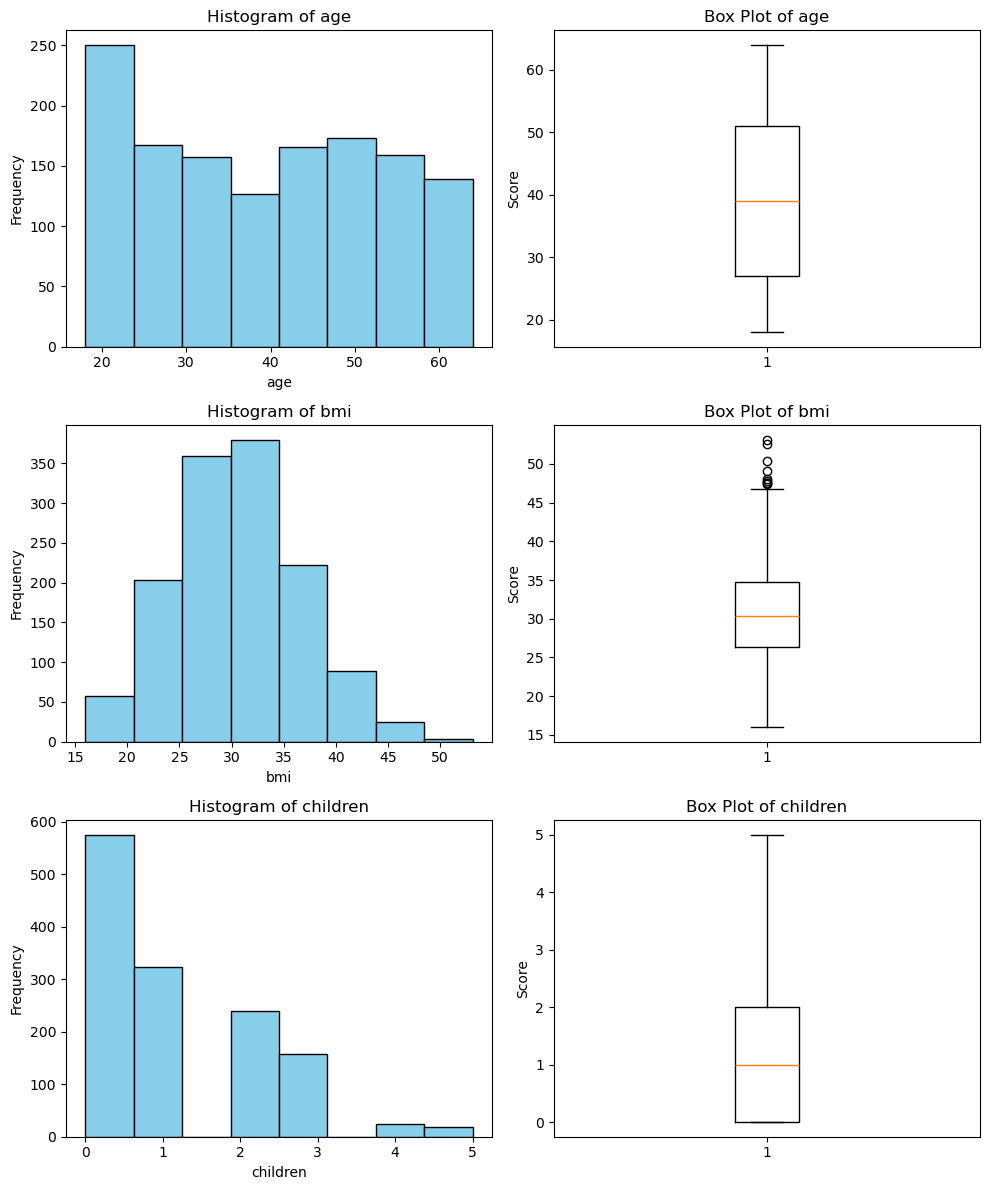

In [8]:
# df.boxplot(column=numerical_attribute)
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=len(numerical_attribute), ncols=2, figsize=(10, 4 * len(numerical_attribute)))

for row, attribute in enumerate(numerical_attribute):
	# Histogram
	axes[row, 0].hist(df[attribute], bins=8, color='skyblue', edgecolor='black')
	axes[row, 0].set_title(f'Histogram of {attribute}')
	axes[row, 0].set_xlabel(attribute)
	axes[row, 0].set_ylabel('Frequency')

	# Box plot
	axes[row, 1].boxplot(df[attribute], vert=True)
	axes[row, 1].set_title(f'Box Plot of {attribute}')
	axes[row, 1].set_ylabel('Score')

# Display
plt.tight_layout()
plt.show()


In [9]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [10]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [11]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

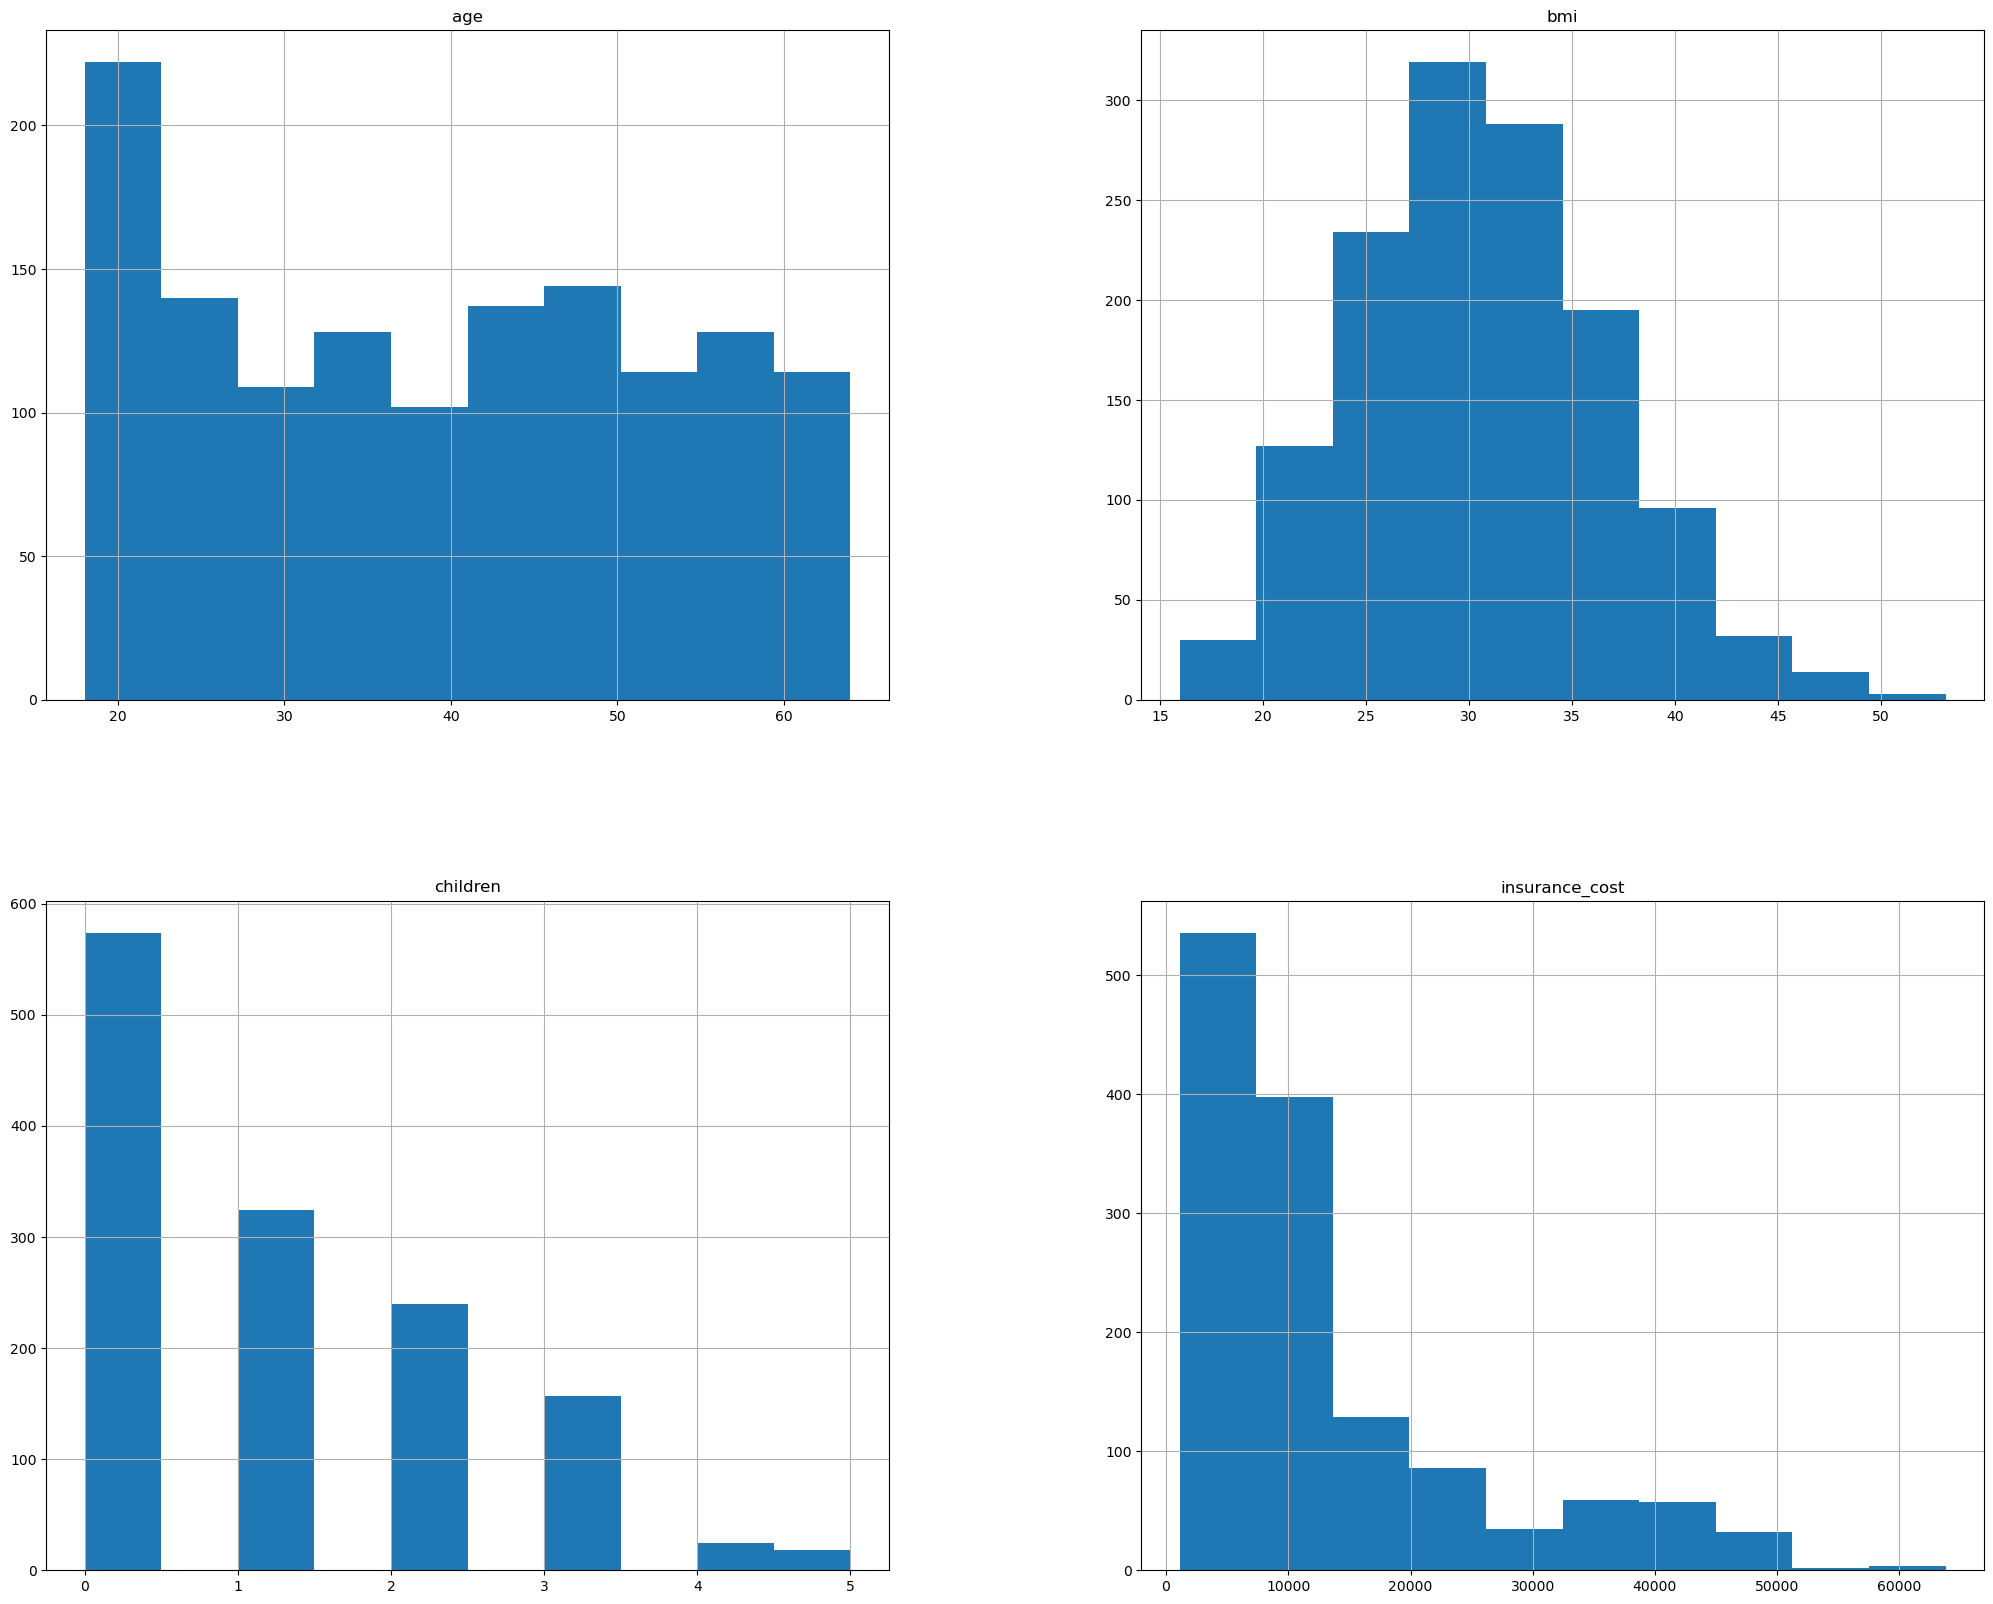

In [12]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

|Type| Attribute | Has Zeros | Outliers | Skewed | Map Values | Imput | Scale| One Hot Encode |Comment|
|-----|-----------|----------|----------|--------|------------|-------|------|----------------|----|
|| Age       | No| No |        | No         |            |       | |                | ||
|| Bmi       | No| Yes |        | No         |            |       | |                | ||
|| Children  | Yes|No| Right  | No         |            |       | |                | ||
|| Gender    | No ||        | Yes        |            |       |       |       |                | ||
|| Region    | No   | |        | Yes               |            |       |       |       |                | ||
|| Smoker    | No    ||        | Yes    |            |            |       | |                | ||

Pipeline

In [13]:
def map_gender(X):
	X = X.copy()
	X['gender'] = X['gender'].map({'male': 0, 'female': 1})
	return X


def map_smoker(X):
	X = X.copy()
	X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1})
	return X


smoker_mapper = FunctionTransformer(map_smoker)
gender_mapper = FunctionTransformer(map_gender)


In [14]:


###################
num_pipeline = Pipeline(steps=[

	('address_right_skew', ColumnTransformer(
		transformers=[
			('log_transform', FunctionTransformer(np.log1p), ['children'])
		],
		remainder="passthrough"
	)
	 ),
	('scaler', StandardScaler())
]
)

cat_pipeline = Pipeline(steps=[
	('attribute_mappers', ColumnTransformer(
		transformers=[
			('gender_mapper', gender_mapper, ['gender']),
			('smoker_mapper', smoker_mapper, ['smoker']),
			('one-hot', OneHotEncoder(sparse_output=False), ['region'])
		]
	)),

])

#
# Use a col transformer to operate on each set separately
#
col_transform = ColumnTransformer(transformers=[
	('num_pipeline', num_pipeline, numerical_attribute),
	('cat_pipeline', cat_pipeline, categorical_attribute)
], remainder='drop', n_jobs=-1)

# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
	('preprocess', col_transform),

])


In [15]:
median_cost = df['insurance_cost'].median()

print(f"Median Cost {median_cost}")

# compare cost against median, convert True / false to 1 / 0
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)
df.drop('insurance_cost', axis=1, inplace=True)

y = df['insurance_cost_binary'];
X = df.drop('insurance_cost_binary', axis=1);

print(df)

# check that binary added correctly
binary_counts = df['insurance_cost_binary'].value_counts();
print(binary_counts)

Median Cost 9382.033
      age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]
insurance_cost_binary
0    669

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Dimension Reduction Setup

In [17]:

N_FEATURES_OPTIONS = [2, 4, 5, 7]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

dim_reduction_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	}
]


### SVM Classification Pipeline

In [18]:

# create the pipeline
svm_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('svm', svm.SVC(probability=True))
])

In [19]:
set_config(display="diagram")
svm_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x13d6d6660>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x13d6d7560>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [20]:


svm_grid_params = [
	{
		'svm__C': [0.1, 1, 10, 100],
		'svm__gamma': [1, 0.1, 0.01, 0.001],
		'svm__kernel': ['rbf', 'linear', 'poly'],

		'reduce_dim': [RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
	},
	{
		'svm__C': [0.1, 1, 10, 100],
		'svm__gamma': [1, 0.1, 0.01, 0.001],
		'svm__kernel': ['rbf', 'linear', 'poly'],

		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
	},
	{
		'svm__C': [0.1, 1, 10, 100],
		'svm__gamma': [1, 0.1, 0.01, 0.001],
		'svm__kernel': ['rbf', 'linear', 'poly'],

		'reduce_dim': [SelectKBest(score_func=f_classif, k=5)],
	}
]

search = GridSearchCV(svm_pipe, svm_grid_params, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.926:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 7, 'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


### Random Forest Classification Pipeline

In [21]:


random_forest_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
									 ('reduce_dim', 'passthrough'),
									 ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))

									 ]
							  )
set_config(display="diagram")
random_forest_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x13d6d6660>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x13d6d7560>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [22]:
random_forest_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_classif, k=5)],
	}
]

search = GridSearchCV(random_forest_pipe, random_forest_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
random_forest_best_params = search.best_params_
random_forest_best_model = search.best_estimator_

Best CV score = 0.929:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 7}


### kNN Classification Pipeline

In [23]:
# create the pipeline
knn_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('knn', KNeighborsClassifier())
])

set_config(display="diagram")
knn_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x13d6d6660>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x13d6d7560>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('knn', KNeighborsClassifier())])

In [24]:



knn_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'knn__n_neighbors': list(range(1, 21)),
		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'knn__n_neighbors': list(range(1, 21)),
		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_classif, k=5)],
		'knn__n_neighbors': list(range(1, 21)),
		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']

	},
]

search = GridSearchCV(knn_pipe, knn_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_


Best CV score = 0.930:
Best parameters:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 12, 'knn__weights': 'uniform', 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}


## Compare Classification Models on Test Set

In [25]:


# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
	# compute probabilistic predictiond for the evaluation set
	_probabilities = model.predict_proba(X_test)[:, 1]

	# compute exact predictiond for the evaluation set
	_predicted_values = model.predict(X_test)

	# compute accuracy
	_accuracy = accuracy_score(y_test, _predicted_values)

	# compute precision, recall and f1 score for class 1
	_precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

	# compute fpr and tpr values for various thresholds
	# by comparing the true target values to the predicted probabilities for class 1
	_fpr, _tpr, _ = roc_curve(y_test, _probabilities)

	# compute true positive rates for the values in the array mean_fpr
	_tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

	# compute the area under the curve
	_auc = auc(_fpr, _tpr)

	return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [26]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [27]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test,
																				   random_forest_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, knn_best_model)

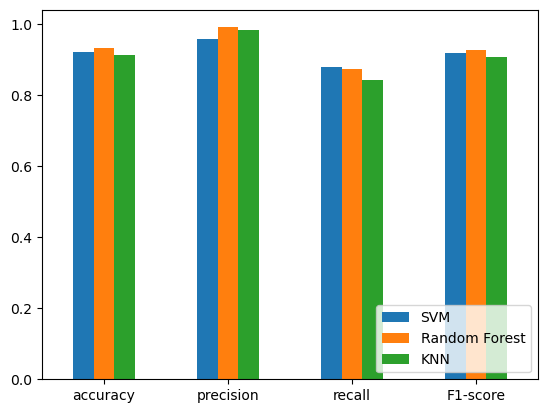

In [28]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [30]:
print(SVM_metrics)
print(RF_metrics)
print(KNN_metrics)

[0.92164179 0.95934959 0.88059701 0.91828794]
[0.93283582 0.99152542 0.87313433 0.92857143]
[0.9141791  0.9826087  0.84328358 0.90763052]


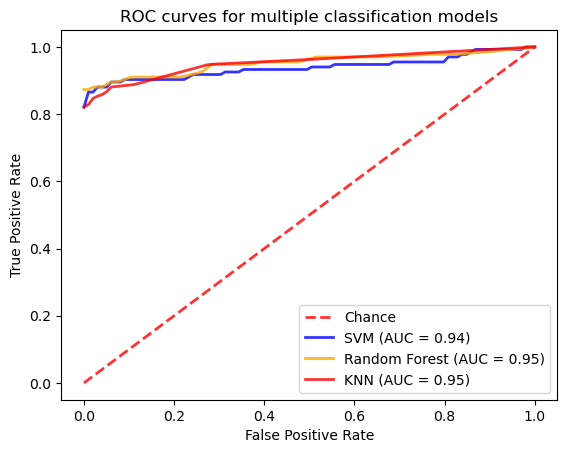

In [29]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0, :], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0, :], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0, :], lw=2, color='red', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance

Definitions
1. F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

1. The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.
2. The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
3. The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.  The best value is 1 and the worst value is 0.